<font size="9">Finding over-represented functions within a proteomic sample<font size="9">

Given a single proteomic sample with an accompanying metagenome, our goal in this notebook is to suggest functional annotations which may be overrepresented among the identified proteins. 
To do this we:

1) Access the sample records with API endpoints.

2) Download the protein report for the sample, as well as the functional GFF of the searched metaproteome.

3) Count the number of times each annotation appeared and find the hypergeometric statistics.

4) Summarize the results and significance with a plot.

In [5]:
import re
import math
import requests
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gffpandas.gffpandas as gffpd

from io import StringIO
from scipy.stats import hypergeom, false_discovery_control
from pathlib import Path
from urllib.parse import parse_qsl, urlencode

<font size="9">Accessing records through API<font size="9">

Given a biosample id, we first access the biosample information on the NMDC using the 'find/biosample' endpoint. From this response we obtain the
studyid associated with the biosample. 

Then, using the studyid, we find all data objects associated to that biosample, with help from the 'find/data_objects/study/study_id' endpoint. 
We store just the relevant information in the output, meaning we keep only the protein_reports for the biosample, the associated FASTA and the GFF.  
The functions above help to automate this process. 

In [6]:
def get_reports_biosample(biosample_id):
    """
    Get the protein reports, GFF and FASTA urls for the given biosample.
    Result is a dictionary with a key for the GFF, FASTA and Protein Reports. 

    We first find the studyid associated with the biosample, fetch the object urls associated with the studyid,
    and then subset those to the specific biosample given.

    Keyword arguments:
    biosample_id -- the NMDC biosample ID of interest. Biosample MUST have an associated protein report!

    """

    biosample_id_ = biosample_id.replace(':', '%3A')
    url = f'https://api.microbiomedata.org/biosamples/{biosample_id_}'
    resp = requests.get(url)
    data = resp.json()
    studyids = data['associated_studies']
    if len(studyids) > 1:
        print("More than one study associated with biosample.")
        print(studyids)
        print(f"Selecting {studyids[0]}")
    studyid = studyids[0]
    all_results = get_reports_studyid(studyid)
    all_results = all_results[f'biosample_{biosample_id}']

    gffs = all_results['GFF']
    gffs = [x for x in gffs if 'Functional Annotation for ' in x['description']]
    assert len(gffs) == 1
    all_results['FASTA'] = all_results['FASTA'][0]
    all_results['GFF'] = gffs[0]
    return all_results



def get_reports_studyid(studyid):

    """
    Get all protein report urls for all biosamples from the given studyid.
    Result is a dictionary with a key for every biosample that has a protein report.

    Keyword arguments:
    studyid -- the NMDC study ID of interest.

    """

    studyid = studyid.replace(':', '%3A')
    url = f'https://api.microbiomedata.org/data_objects/study/{studyid}'
    all_results = dict()
    resp = requests.get(url)
    data = resp.json()
    for biosample in data:
        biosample_id = biosample['biosample_id']
        new_entry = dict()
        new_entry['protein_reports'] = []
        new_entry['FASTA'] = []
        new_entry['GFF'] = []
        data_objects = biosample['data_objects']
        for dobj in data_objects:
            if 'data_object_type' in dobj.keys():
                if dobj['data_object_type'] == 'Protein Report':
                    new_entry['protein_reports'] += [dobj]
                if dobj['data_object_type'] == 'Annotation Amino Acid FASTA': # Excludes contaminant FASTAs
                    new_entry['FASTA'] += [dobj]
                if 'GFF' in dobj['data_object_type']:
                    new_entry['GFF'] += [dobj]
        if len(new_entry['protein_reports']) > 0:
            check_pr_fasta(new_entry)
            all_results[f'biosample_{biosample_id}'] = new_entry
    return all_results

def check_pr_fasta(new_entry):
    """ 
    Interal function to check that:
    1. There's only one FASTA associated with a biosample and
    2. That FASTA has ID listed in the name of protein report for that biosample.

    """
    fasta_obj_ids = list(set([_extract_fasta_id(x['name']) for x in new_entry['protein_reports']]))
    assert len(new_entry['FASTA']) == 1
    assert len(fasta_obj_ids) == 1
    assert new_entry['FASTA'][0]['id'] == fasta_obj_ids[0]

def _extract_fasta_id(protein_report_name):
    """ 
    Interal function to extract the fasta nmdc ID from the protein report name

    """
    try:
        out = re.search('nmdc_dobj.*_nmdc_dobj(.*)_Protein_Report.tsv', protein_report_name).group(1)
        out = f'nmdc:dobj{out}'
    except:
        out = ''
    return out

For our purposes, the function of interest here is `get_reports_biosample`:

In [9]:
test = get_reports_biosample('nmdc:bsm-13-bgefg837')

Below we can see an example of the API response. It contains:

1) All the protein reports for that biosample (usually a single file).

2) The associated FASTA

3) The Functional GFF for the biosample. 

Note that only the functional annotation GFF is kept in these results. It contains all the relevant annotations (pfam, COG, etc) in a single GFF. Each of entry has a 'url' field, which lets us access the actual file.

In [10]:
test

{'protein_reports': [{'id': 'nmdc:dobj-11-xnhnfq72',
   'name': 'nmdc_dobj-11-9gcej008_nmdc_dobj-11-j5mh8584_Protein_Report.tsv',
   'description': 'Aggregated protein lists from MSGF+ search results filtered to ~5% FDR',
   'file_size_bytes': 5470064,
   'md5_checksum': '92a123898487447501b27ff97847df23',
   'data_object_type': 'Protein Report',
   'url': 'https://nmdcdemo.emsl.pnnl.gov/proteomics/results/nmdc_dobj-11-9gcej008_nmdc_dobj-11-j5mh8584_Protein_Report.tsv',
   'type': 'nmdc:DataObject',
   'in_manifest': ['nmdc:manif-11-91gc1f77']},
  {'id': 'nmdc:dobj-11-02f4sr80',
   'type': 'nmdc:DataObject',
   'name': 'nmdc_dobj-11-9gcej008_nmdc_dobj-11-j5mh8584_Protein_Report.tsv',
   'description': 'Aggregated protein lists from MSGF+ search results filtered to ~5% FDR',
   'data_object_type': 'Protein Report',
   'file_size_bytes': 57999620,
   'md5_checksum': '496450d6f24f5c98730d1d7bf7f904a2',
   'url': 'https://nmdcdemo.emsl.pnnl.gov/proteomics/results/2/nmdc_dobj-11-9gcej008_nm

<font size="9">Download protein report and GFF<font size="9">

To access these files via python, we use the `requests` library. 

Now we want to read the protein reports associated with the sample. Each of these reports is made from the .raw files associated with the sample, and lists the annotations for each of the identified proteins. If there are multiple protein reports per raw file, by default we select the latest protein report generated by a 'matched_metagenome' metaproteomic workflow. If this is not possible, we alert the user and print information for all the protein reports we have, to allow the user to supply a new 'workflow_type' value to use. 

Likewise, we use the `gffpandas` package to read in the GFF annotations. This is typically a large file (over 600Mb) so it can take a few minutes to download and to process.
Once we have the raw file downloaded, we load it into a dataframe using `gffpandas`. The resulting dataframe has annotations listed for ALL of the proteins that were searched when producing the protein report, with each annotation category (like pfam) in its own column.

In [11]:
def read_protein_report(results_dict, workflow_type = 'matched_metagenome'):
    """ 
    Function to read the protein reports. 

    Keyword arguments:
    results_dict -- The output of the function `get_reports_biosample`, which contains the urls for the protein reports.

    """
    # all_results = dict()
    dfs = []
    by_name = dict()
    ## Organize all results by raw file:
    for protein_report in results_dict['protein_reports']:
        if 'was_generated_by' in protein_report.keys():
            wrkflw_id = protein_report['was_generated_by']
            url = f'https://api.microbiomedata.org/objects/{wrkflw_id.replace("nmdc:", "")}'
            resp = requests.get(url)
            data = resp.json()
            protein_report['workflow_type'] = data['metaproteomics_analysis_category']
            protein_report['completion_date'] = data['ended_at_time']
        else:
            protein_report['workflow_type'] = ''
            protein_report['completion_date'] = ''
        name = protein_report['name']
        if name not in by_name.keys():
            by_name[name] = [protein_report]
        else:
            by_name[name] += [protein_report]  

   
    to_read = dict()
    workflow_present = [any([y['workflow_type'] == workflow_type for y in xx]) for xx in [x for x in by_name.values()]]
    lens = [len(x) for x in by_name.values()]
    ## If only ONE report is present per raw file, we use those
    if all([y == 1 for y in lens]):
        for name in by_name.keys():
            for protein_report in by_name[name]:
                to_read[name] = protein_report
    ## If there are multiple protein reports per raw file, we check if the request workflow type is present for each raw file. If so, we use the latest report for that workflow type.
    elif all(workflow_present):
        for name in by_name.keys():
            for protein_report in by_name[name]:
                if protein_report['workflow_type'] == workflow_type:
                    if name in to_read.keys():
                        ## If multiple protein reports from the same workflow type AND raw file are found, use the latest one!
                        if to_read[name]['completion_date'] <= protein_report['completion_date']:
                            to_read[name] = protein_report
                    else:
                        to_read[name] = protein_report
        
    ## If multiple report per raw file exist, AND if not all raw files have a protein report with the requested workflow type, THEN we ask for more input from the user:
    else:
        print(f"Multiple protein reports per raw file, and not all have the requested workflow type ({workflow_type}). Please specify another metaproteomic_workflow_type to use.")
        for name in by_name.keys():
            workflow_types = [y['workflow_type'] for y in by_name[name]]
            print(f'{name} has {workflow_types} workflow_types')
        out = None
    for protein_report in to_read.values():
        url = protein_report['url']
        resp = requests.get(url)
        data = StringIO(resp.text)

        df = pd.read_csv(data, sep="\t")
        dfs = dfs + [df]
        out = pd.concat(dfs)
        if 'best_protein' in out.columns and 'razor_protein' not in out.columns:
            out['razor_protein'] = out['best_protein']
    return out

def read_gff(results_dict):
    """ 
    Function to read the GFF. 

    Keyword arguments:
    results_dict -- The output of the function `get_reports_biosample`, which contains the urls for the GFF.

    """
    warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)
    url = results_dict['GFF']['url']
    resp = requests.get(url)
    local_temp = Path('./temp_gff.gff')
    with local_temp.open('w') as file:
        for line in resp:
            file.write(line.decode('utf-8'))

    local_temp = Path('temp_gff.gff')
    # local_temp_ = Path('temp_gff_.gff')
    df = gffpd.read_gff3(local_temp)
    df = df.attributes_to_columns()
    df = df.drop('attributes', axis=1)
    local_temp.unlink()
    return df

protein_report = read_protein_report(test)
functional_gff = read_gff(test)

Below, we have the first few rows in the protein report:

In [12]:
protein_report[0:7]

,DatasetName,razor_protein,Product,EC_Number,pfam,KO,COG,GeneCount,all_proteins,AnnotationList,UniquePeptideCount,SummedSpectraCounts,SummedPeptideMASICAbundances
0,SpruceW_P4_15A_22Jun17_Pippin_17-04-06,nmdc:wfmgan-11-pmh0a992.1_0015462_505_2979,ATP-dependent Clp protease ATP-binding subunit...,NaN,"PF00004,PF02861,PF07724,PF10431,PF17871",KO:K03696,COG0542,397,nmdc:wfmgan-11-pmh0a992.1_0000039_126009_12865...,gene_name=nmdc:wfmgan-11-pmh0a992.1_0018823_20...,7.0,8.0,1.434427e+10
1,SpruceW_P4_15A_22Jun17_Pippin_17-04-06,nmdc:wfmgan-11-pmh0a992.1_0001435_14413_16890,ATP-dependent Clp protease ATP-binding subunit...,NaN,"PF00004,PF02861,PF07724,PF10431,PF17871",KO:K03696,COG0542,397,nmdc:wfmgan-11-pmh0a992.1_0000039_126009_12865...,gene_name=nmdc:wfmgan-11-pmh0a992.1_0669678_1_...,7.0,8.0,1.434427e+10
2,SpruceW_P4_15A_22Jun17_Pippin_17-04-06,nmdc:wfmgan-11-pmh0a992.1_0004591_5018_7468,ATP-dependent Clp protease ATP-binding subunit...,NaN,"PF00004,PF02861,PF07724,PF10431,PF17871",KO:K03696,COG0542,387,nmdc:wfmgan-11-pmh0a992.1_0000039_126009_12865...,gene_name=nmdc:wfmgan-11-pmh0a992.1_0477425_2_...,7.0,8.0,1.498534e+10
3,SpruceW_P4_15A_22Jun17_Pippin_17-04-06,nmdc:wfmgan-11-pmh0a992.1_0000119_69369_71816,ATP-dependent Clp protease ATP-binding subunit...,NaN,"PF00004,PF02861,PF07724,PF10431,PF17871",KO:K03696,COG0542,387,nmdc:wfmgan-11-pmh0a992.1_0000039_126009_12865...,gene_name=nmdc:wfmgan-11-pmh0a992.1_0557305_2_...,7.0,8.0,1.498534e+10
4,SpruceW_P4_15A_22Jun17_Pippin_17-04-06,nmdc:wfmgan-11-pmh0a992.1_0087757_1_1518,ATP-dependent Clp protease ATP-binding subunit...,NaN,"PF00004,PF07724,PF17871",KO:K03696,COG0542,387,nmdc:wfmgan-11-pmh0a992.1_0000039_126009_12865...,gene_name=nmdc:wfmgan-11-pmh0a992.1_0000431_27...,7.0,8.0,1.498534e+10
5,SpruceW_P4_15A_22Jun17_Pippin_17-04-06,nmdc:wfmgan-11-pmh0a992.1_0002529_5667_8111,ATP-dependent Clp protease ATP-binding subunit...,NaN,"PF00004,PF02861,PF07724,PF10431,PF17871",KO:K03696,COG0542,387,nmdc:wfmgan-11-pmh0a992.1_0000039_126009_12865...,gene_name=nmdc:wfmgan-11-pmh0a992.1_1552042_2_...,7.0,8.0,1.498534e+10
6,SpruceW_P4_15A_22Jun17_Pippin_17-04-06,nmdc:wfmgan-11-pmh0a992.1_0002580_865_3312,ATP-dependent Clp protease ATP-binding subunit...,NaN,"PF00004,PF02861,PF07724,PF10431,PF17871",KO:K03696,COG0542,387,nmdc:wfmgan-11-pmh0a992.1_0000039_126009_12865...,gene_name=nmdc:wfmgan-11-pmh0a992.1_1163833_2_...,7.0,8.0,1.498534e+10


As well as the associated GFF:

In [13]:
functional_gff[0:7]

,seq_id,source,type,start,end,score,strand,phase,ID,Parent,...,pfam,product,product_source,regulatory_class,smart,start_type,superfamily,tigrfam,translation_table,used_search_mode
0,nmdc:wfmgan-11-pmh0a992.1_0000001,GeneMark.hmm-2 v1.25_lic,CDS,2,127,3.81,+,0,nmdc:wfmgan-11-pmh0a992.1_0000001_2_127,None,...,None,hypothetical protein,Hypo-rule applied,None,None,TTG,None,None,11,None
1,nmdc:wfmgan-11-pmh0a992.1_0000001,Prodigal v2.6.3_patched,CDS,260,1072,41.7,-,0,nmdc:wfmgan-11-pmh0a992.1_0000001_260_1072,None,...,PF01636,hypothetical protein,Hypo-rule applied,None,None,ATG,56112,None,11,None
2,nmdc:wfmgan-11-pmh0a992.1_0000001,Prodigal v2.6.3_patched,CDS,1507,2487,16.8,+,0,nmdc:wfmgan-11-pmh0a992.1_0000001_1507_2487,None,...,"PF00665,PF09039",putative transposase,KO:K07497,None,None,TTG,"46689,53098",None,11,None
3,nmdc:wfmgan-11-pmh0a992.1_0000001,Prodigal v2.6.3_patched,CDS,2682,3215,11.2,+,0,nmdc:wfmgan-11-pmh0a992.1_0000001_2682_3215,None,...,PF20020,hypothetical protein,Hypo-rule applied,None,None,ATG,None,None,11,None
4,nmdc:wfmgan-11-pmh0a992.1_0000001,Prodigal v2.6.3_patched,CDS,3149,3775,36.0,-,0,nmdc:wfmgan-11-pmh0a992.1_0000001_3149_3775,None,...,PF00578,peroxiredoxin,COG1225,None,None,GTG,52833,None,11,None
5,nmdc:wfmgan-11-pmh0a992.1_0000001,GeneMark.hmm-2 v1.25_lic,CDS,3772,4971,53.53,-,0,nmdc:wfmgan-11-pmh0a992.1_0000001_3772_4971,None,...,None,hypothetical protein,Hypo-rule applied,None,None,ATG,None,None,11,None
6,nmdc:wfmgan-11-pmh0a992.1_0000001,Prodigal v2.6.3_patched,CDS,5079,5828,18.9,-,0,nmdc:wfmgan-11-pmh0a992.1_0000001_5079_5828,None,...,None,hypothetical protein,Hypo-rule applied,None,None,ATG,None,None,11,None


<font size="9">Collecting hypergeometric statistics<font size="9">

Next, we treat our identified proteins as a 'random sample drawn without replacement' from a larger set of proteins in the protein database, as shown below.

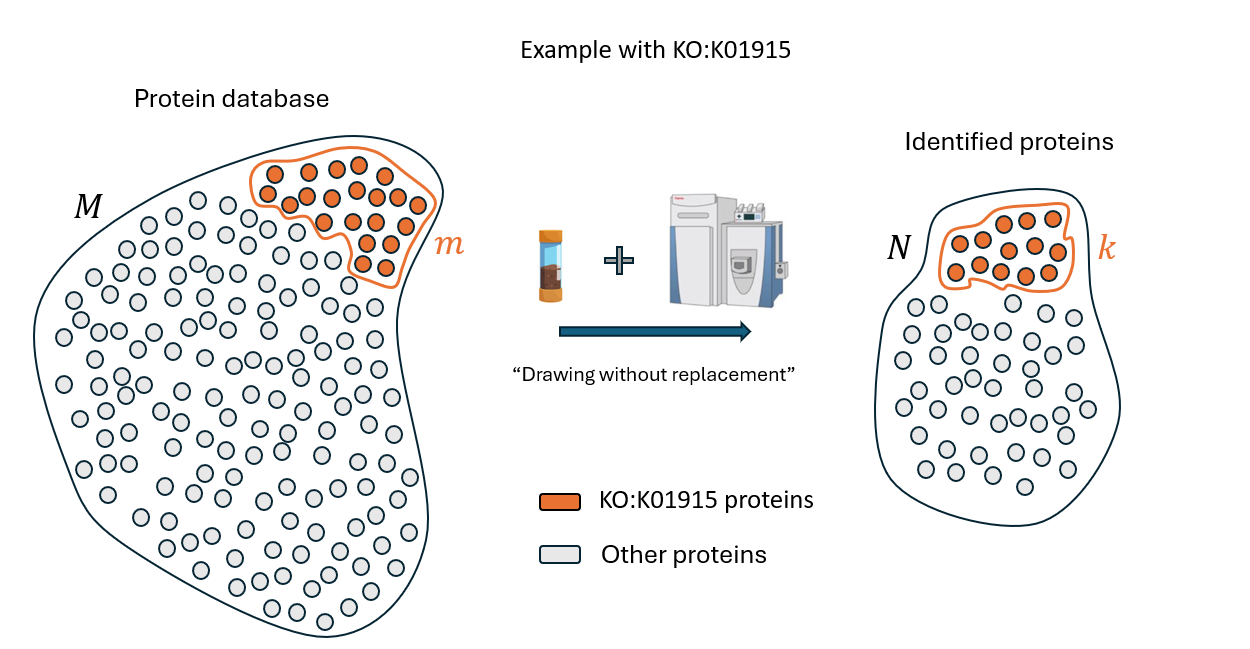

More specifically, we iterate through the protein report, counting the total number of times each annotation is identified. We also iterate through the functional GFF to count the total number of proteins that COULD have been identified for each annotation. Dictionaries are used to keep track of both of these counts. Then we use `scipy`'s `hypergeom` function to compute the pvalues, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.hypergeom.html. For each given annotation $\textrm{Ann}$ we find:

1) $m = $ Number of possible proteins having the annotation $\textrm{Ann}$. This is found in the GFF. Called $n$ by the `scipy` documentation. 

2) $k = $ Number of unique identified proteins having the annotation $\textrm{Ann}$. This is found in the protein reports. Same $k$ as the `scipy` documentation.

3) $M = $ Total number of proteins searched. We find this from the GFF. Same $M$ as the `scipy` documentation.

4) $N = $ Total number of unique proteins identified. We find this from the protein reports. Same $N$ as the `scipy` documentation.

We use these counts to compute the probability of identifying at least $k$ proteins with annotation $\textrm{Ann}$, given that a total of $M$ proteins could be identified. We find this using the survival function of the hypergeometric distribution: `hypergeom.sf(k-1, M, m, N)`. The number `k-1` is used since we want the probability of identifying at least $k$ proteins with annotation $\textrm{Ann}$, and the survival function is $1 - \textrm{cdf}$.

The function below takes as input a protein report, a gff dataframe, and one of the possible annotation families outlined in the gff. Common families include: pfam, COG, EC and KO. 

DISCLAIMER: When interpreting the pvalues, it's important to keep in mind the simplfication we have made here: We are treating a complex process (protein identification) as "drawing (from the protein database) without replacement". This is a rough approximation to reality, since not every protein is equally likely to be detected for example. Likewise, two annotations can overlap, for example related Pfam domains can share many proteins, and so the counts on each annotation are not necessarily independent from each other. With that said, the hypergeometric test is meant to highlight annotations of interest for further study.

In [14]:
def find_overrep(protein_report, gff, annotation_category):
    """ 
    Given an `annotation_category` (like pfam), this function
    We count the number of detected proteins associated with each of the annotations from the given `annotation_category`.
    Then for each annotation, we idealize the process of protein identification as random sampling without replacement, and
    use the hypergeometric distribution to estimate the probability that we detect at least the observed number of proteins from that annotation.
    The results contain 4 columns, the annotation name, a fraction showing the number of annotated proteins detected over the total number of annotated proteins, 
    the pvalue and finally the BH adjusted pvalue.

    Keyword arguments:
    protein_report -- The protein report (pandas dataframe). The output of the function `read_protein_report`.
    gff -- The gff (pandas dataframe). The output of the function `read_gff`.
    annotation_category -- Any column name from the gff.

    """

    if (annotation_category == 'attributes'):
        avail = [column for column in gff.columns if column not in ['attributes']]
        print("The attributes in the gff have been parsed by gffpandas. Each category can be found in a single column.")
        print(f'These are the possible columns {avail}')
        return None
    functional_gff = gff
    gff_annotations = functional_gff[f'{annotation_category}'].tolist()
    gff_annotations = [x for x in gff_annotations if x is not None]
    gff_annotations = [str(x) for x in gff_annotations]
    annotation_counts = dict()

    for annotation in gff_annotations:
        if annotation is not None:
            annotation_split = annotation.split(',')
            for single_annotation in annotation_split:
                if single_annotation not in annotation_counts.keys():
                    annotation_counts[single_annotation] = 1
                else:
                    annotation_counts[single_annotation] += 1

    # a = list(yy.ID)
    functional_gff.index = functional_gff.ID
    identified_proteins = list(set([x for x in protein_report.razor_protein if 'Contaminant' not in str(x)]))
    identified_annotations = functional_gff.loc[identified_proteins][f'{annotation_category}'].tolist()
    identified_annotations = [x for x in identified_annotations if x is not None]
    identified_annotations = [str(x) for x in identified_annotations]

    if [x for x in identified_annotations if x is not None] == []:
        print(f'No proteins with annotations from the supplied colum ({annotation_category}) were identified in the protein report.')

    id_annotation_counts = dict()
    for annotation in identified_annotations:
        if annotation is not None:
            annotation_split = annotation.split(',')
            for single_annotation in annotation_split:
                if single_annotation not in id_annotation_counts.keys():
                    id_annotation_counts[single_annotation] = 1
                else:
                    id_annotation_counts[single_annotation] += 1

    total_id_proteins = len(identified_proteins)
    total_proteins = len(functional_gff)
    overrep_results = dict()

    for annotation in id_annotation_counts.keys():
        M, m, N, x = total_proteins, annotation_counts[annotation], total_id_proteins, id_annotation_counts[annotation]
        pval = float(hypergeom.sf(x-1, M, m, N))
        ann_results = dict()
        ann_results['pvalue'] = pval
        ann_results['ratio'] = f'{x}/{m}'
        overrep_results[annotation] = ann_results

    adj_pvals = false_discovery_control([x['pvalue'] for x in overrep_results.values()], method = 'BH')

    for annotation, adj_pval in zip(id_annotation_counts.keys(), adj_pvals):
        overrep_results[annotation]['adj_pval'] = adj_pval

    overrep_results_df = pd.DataFrame({'annotation' : list(overrep_results.keys()),
                                       'ratio' : [x['ratio'] for x in overrep_results.values()],
                                       'pvalue' : [x['pvalue'] for x in overrep_results.values()],
                                       'adj_pvalue' : [x['adj_pval'] for x in overrep_results.values()]})
    
    return overrep_results_df

Below we show the use of the function, as well as the output it produces. Notice we report both the pvalue and the adjusted pvalue, which we obtain using the usual Benjamini-Hochberg (BH) method. We also show the number of times each annotation was identified, as well as the total number of proteins in the GFF with that annotation.

Those annotations with more proteins identified (the numerator) tend to have lower pvalues. 

In [15]:
overrep_results_df_pfam = find_overrep(protein_report, functional_gff, 'pfam')
overrep_results_df_pfam

,annotation,ratio,pvalue,adj_pvalue
0,PF00208,29/331,4.972420e-23,2.849365e-22
1,PF02812,35/276,4.790949e-33,4.072307e-32
2,PF04366,138/476,8.753660e-179,1.488122e-176
3,PF03976,142/753,1.905795e-154,2.429889e-152
4,PF00391,30/376,1.360579e-22,7.667354e-22
...,...,...,...,...
1015,PF02504,1/332,8.931322e-01,1.000000e+00
1016,PF01442,1/4,2.658017e-02,5.154329e-02
1017,PF02729,1/530,9.718422e-01,1.000000e+00
1018,PF00239,1/1296,9.998385e-01,1.000000e+00


We can use another family, like KO, to compute the results:

In [16]:
overrep_results_df_ko = find_overrep(protein_report, functional_gff, 'ko')
overrep_results_df_ko[0:7]

,annotation,ratio,pvalue,adj_pvalue
0,KO:K00262,14/77,2.119950e-16,9.820157e-16
1,KO:K01006,62/857,1.997881e-42,2.561568e-41
2,KO:K00134,71/459,1.266367e-71,4.785533e-70
3,KO:K02961,29/216,2.180491e-28,1.630825e-27
4,KO:K01915,143/1313,2.708959e-120,2.431291e-118
5,KO:K07246,12/128,9.631180e-11,3.492519e-10
6,KO:K02338,55/517,9.110181e-47,1.486616e-45


We can see which annotation families we can use in the `find_overrep` function by calling `functional_gff.columns`:

In [17]:
functional_gff.columns

Index(['seq_id', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase',
       'ID', 'Parent', 'accession', 'average_repeat_length',
       'average_spacer_length', 'bound_moiety', 'cath_funfam', 'codon', 'cog',
       'e-value', 'ec_number', 'intron_end', 'intron_start', 'ko',
       'median_repeat_length', 'median_spacer_length', 'model', 'model_end',
       'model_start', 'ncRNA_class', 'note', 'number_of_repeats', 'partial',
       'pfam', 'product', 'product_source', 'regulatory_class', 'smart',
       'start_type', 'superfamily', 'tigrfam', 'translation_table',
       'used_search_mode'],
      dtype='object')

All but one of these columns can be used to find overrepresentation of the annotations in that column. The only exception is the 'attributes' column. The GFF format uses this column to store ALL the annotations of a protein in a single string. This column has already been parsed by `gffpandas`, and each annotation family is placed into its own column (like pfam, ko, etc).

In [18]:
overrep_results_df_superfam = find_overrep(protein_report, functional_gff, 'superfamily')
overrep_results_df_superfam

,annotation,ratio,pvalue,adj_pvalue
0,51735,634/40188,5.133604e-82,1.365539e-80
1,53223,51/1089,2.249663e-26,1.584712e-25
2,52540,1748/78933,0.000000e+00,0.000000e+00
3,51621,80/3029,6.150018e-24,3.941939e-23
4,52009,27/339,1.799523e-20,1.075670e-19
...,...,...,...,...
527,103456,1/26,1.606350e-01,2.916649e-01
528,117130,1/99,4.866380e-01,7.845194e-01
529,53671,1/890,9.975095e-01,1.000000e+00
530,53041,1/1171,9.996250e-01,1.000000e+00


<font size="9">Summarizing results<font size="9">

Finally, we can plot these results using `pyplot`. The function below sorts the results according to their adjusted pvalue. By default we plot the top 20 most significant annotations, but we can change this by giving a different value of `N` to the function.

In [19]:
def plot_results(results, title = '', N = 20):
    """ 
    Given the results table from the function `find_overrep`, we plot the top N most significant results.

    Keyword arguments:
    results -- The output of the function `find_overrep`.
    N -- Number of annotations to plot.

    """
    results = results.sort_values('pvalue')
    results = results[0:N]
    # counts = [int(r.split('/')[0])/int(r.split('/')[1]) for r in results.ratio]
    counts = [int(r.split('/')[0]) for r in results.ratio]
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.barh(results.annotation, counts)
    ax1.set_xlabel("Number of proteins")
    ## Since some pvalues are zero, coming out of the scipy hypergeom cdf, we add a little bit to avoid the singularity
    log_pvals = [-math.log10(pval + 1e-200) for pval in results.adj_pvalue]  
    ax2.barh(results.annotation, log_pvals)
    ax2.set_yticks([])
    ax2.set_xlabel('adj_pvalue')
    max_log, min_log = max(log_pvals), min(log_pvals)
    tick_distance = (max_log - min_log)*0.1
    x_ticks = [max(int(min_log - 0.7*tick_distance), 1), max(int(min_log + 4*tick_distance), 2), max(int(min_log + 8.5*tick_distance), 3)]
    ax2.set_xticks(x_ticks, labels = ['10$^{-' + f'{x_ticks[0]}' + '}$', '10$^{-' + f'{x_ticks[1]}' + '}$', '10$^{-' + f'{x_ticks[2]}' + '}$'], fontsize = 9)
    fig.suptitle(title)
    plt.show()

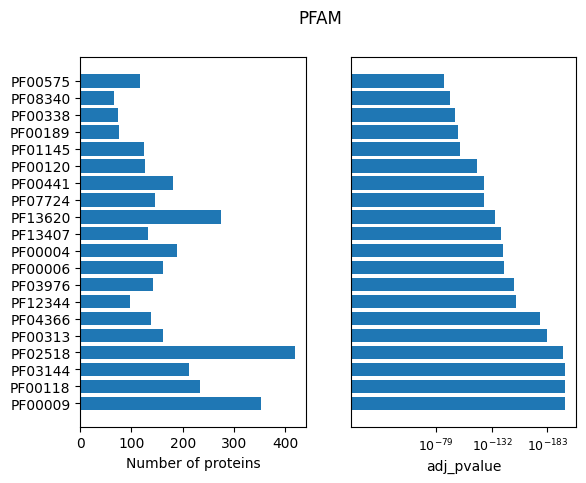

In [20]:
plot_results(overrep_results_df_pfam, title = "PFAM")

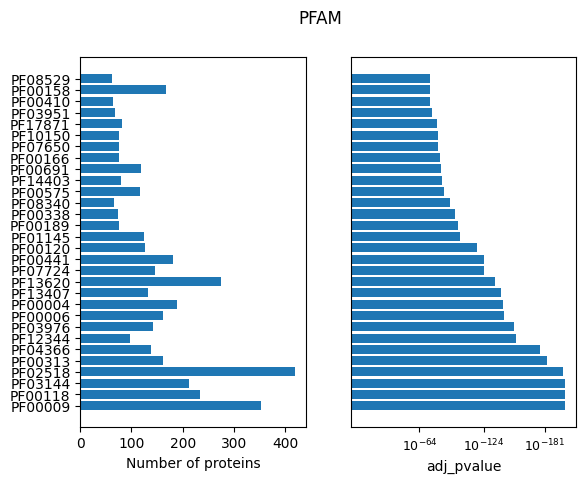

In [21]:
plot_results(overrep_results_df_pfam, title = "PFAM", N = 30)

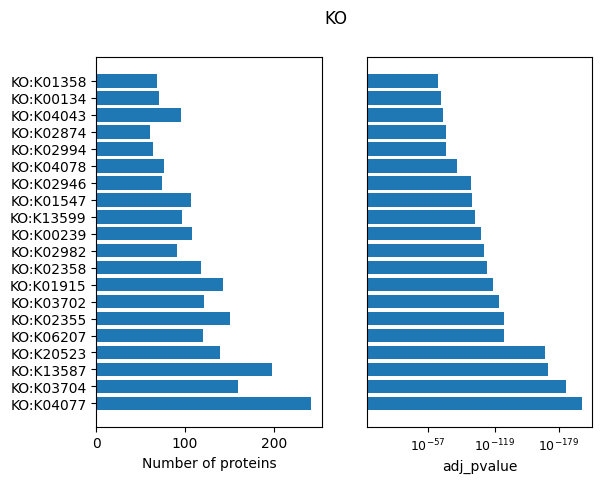

In [22]:
plot_results(overrep_results_df_ko, title = "KO")

We can also visualize the overlap between any set of annotations from the GFF, using the `overlap` function below.

In [23]:
def overlap(terms, gff_df, protein_report):
    """ 
    Given a list of annotation terms, we compute the overlap between all the proteins belonging to the annotations in the list. 
    By 'overlap' between two sets A and B of proteins, we mean the proportion of the union of A and B in common between A and B.
    Ie, |A intersect B|/|A union B|.

    Keyword arguments:
    terms -- A list of terms found in the GFF.
    gff_df -- the functional annotation GFF
    protein_report -- the protein report.

    """
    identified_proteins = list(set([x for x in protein_report.razor_protein if 'Contaminant' not in x]))
    term_members = dict()
    likely_cols = ['ko', 'pfam']

    ## Extract the protein members of the given terms
    for col in set(likely_cols + list(gff_df.columns)):
        if col in gff_df.columns and not all([term in term_members.keys() for term in terms]):
            gff_annotations = [str(x) for x in gff_df[col].tolist()]
            proteins = gff_df['ID'].tolist()
            for annotation, protein in zip(gff_annotations, proteins):
                if annotation is not None:
                    annotation_split = annotation.split(',')
                    for single_annotation in annotation_split:
                        if single_annotation in terms:
                            if single_annotation not in term_members.keys():
                                term_members[single_annotation] = set([protein])
                            else:
                                term_members[single_annotation].add(protein)

    not_found = set(terms) - set(term_members.keys())
    if len(not_found) > 0:
        print(f'Warning, did not find the following terms in the GFF: {not_found}')

    terms = list(term_members.keys())
    overlap = dict()
    for i, term1 in enumerate(terms):
        for term2 in terms[0:i]:
            common_members = term_members[term1].intersection(term_members[term2])
            all_members = term_members[term1].union(term_members[term2])
            x, y = len(common_members)/len(all_members), len(common_members.intersection(identified_proteins))/len(all_members.intersection(identified_proteins))

            if (x > 0):
                lab_x, lab_y = str(round(x, 2)), str(round(y, 2))
            else:
                lab_x, lab_y = '', ''
            overlap[(term1, term2)] = (x, y, lab_x, lab_y)
            overlap[(term2, term1)] = (x, y, lab_x, lab_y)
            overlap[(term1, term1)] = (1, 1, '', '')
            overlap[(term2, term2)] = (1, 1, '', '')
    output_df = pd.DataFrame({'term1': [x[0] for x in overlap.keys()], 'term2': [x[1] for x in overlap.keys()],
                              'overlap_background': [x[0] for x in overlap.values()], 'overlap_identified': [x[1] for x in overlap.values()],
                              'overlap_background_lab': [x[2] for x in overlap.values()], 'overlap_identified_lab': [x[3] for x in overlap.values()]})

    x = output_df.pivot(index = 'term1', columns = 'term2', values = 'overlap_identified')
    labs = output_df.pivot(index = 'term1', columns = 'term2', values = 'overlap_identified_lab')
    sns.clustermap(x, cmap = 'Blues', annot = labs, fmt = '')

Now, based on the two plots immediately above, the top annotation in KO is 'KO:K04077' (https://www.genome.jp/dbget-bin/www_bget?ko:K04077), while the top annotation from PFAM is 'PF00118' (https://www.ebi.ac.uk/interpro/entry/pfam/PF00118/). In both cases we have a 'chaperonin' family of proteins associated with heat shock. As we can see from the overlap plot, these two terms share a large number of proteins, despite being from different annotation families (KO and PFAM):

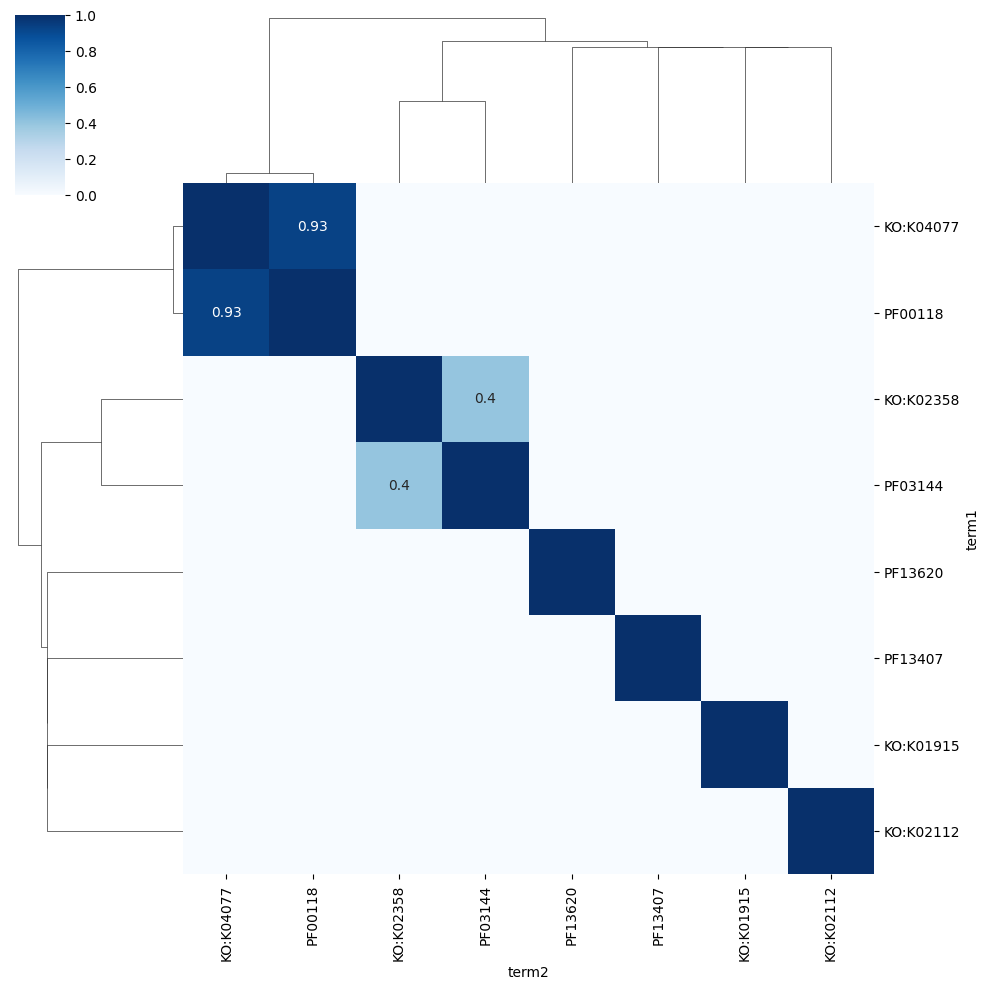

In [24]:
overlap(['KO:K04077', 'PF00118', 'PF13620', 'PF13407', 'PF03144', 'KO:K02358', 'KO:K01915', 'KO:K02112'], functional_gff, protein_report)

Another interesting find is the kegg term 'KO:K01915' (https://www.genome.jp/dbget-bin/www_bget?ko:K01915), which has nearly 100 proteins identified and no overlap with any of the other potentially enriched annotations. This term, 'KO:K01915' is a glutamine synthetase pathway, which plays a crucial role in nitrogen metabolism - sensible given that we are dealing with a soil sample.